In [66]:
import numpy as np
from scipy.stats import wishart

In [67]:
def ranking_matrix(N, M, filename, sep="	"):
    
    R = np.zeros((N, M))
    I = np.zeros((N, M))
    f = open(filename,"r")
    for line in f:
        if line[0] == '%':
            # this is a comment
            continue
        (user, movie, ranking,_) = line.split(sep)
        R[np.int(user) - 1, np.int(movie) - 1] = np.int(ranking)
        I[np.int(user) - 1, np.int(movie) - 1] = 1.0
    return R, I

In [68]:
K = 50
N = 943
M = 1682

In [69]:
R, I = ranking_matrix(N, M, "u1.base")


In [70]:
mu0 = np.zeros(K)
uv0 = K
WU0 = np.eye(K)
mv0 = np.zeros(K)
vv0 = K
WV0 = np.eye(K)
beta0 = 1.0
alpha = 2.0

In [71]:
lambdaU = wishart.rvs(size = 1,df = uv0, scale = WU0)
muU = np.random.multivariate_normal(mu0, np.linalg.pinv(beta0 * lambdaU))
lambdaV = wishart.rvs(size = 1,df = vv0, scale = WV0)
muV = np.random.multivariate_normal(mv0, np.linalg.pinv(beta0 * lambdaV))

In [72]:
U = np.random.multivariate_normal(muU ,lambdaU , N)
V = np.random.multivariate_normal(muV ,lambdaV , M)

In [73]:
U

array([[ 9.16837786e+00,  3.73709645e+00,  1.56889463e+01, ...,
         2.91836135e+00,  2.47331281e+00,  6.03701953e+00],
       [ 1.08843321e+01,  1.00743717e+01, -3.51035978e-01, ...,
         5.75416616e+00,  8.91718572e+00,  1.38156225e+00],
       [ 2.76294488e+00,  1.18287429e-01,  1.10392522e+01, ...,
         7.43106610e+00, -2.00950182e+00, -4.18055287e+00],
       ...,
       [ 1.11614815e+01, -1.06467514e+01,  1.44485437e+01, ...,
         2.39703705e+00, -2.65086434e+00,  8.25205203e-01],
       [-1.44427893e+00,  7.23232074e+00, -3.54189237e+00, ...,
         2.52995274e+00,  8.41237284e+00,  4.82502950e+00],
       [-1.61660735e+00,  3.85688164e-01,  1.35597553e+01, ...,
         6.44267081e+00, -3.78270389e-03, -9.36149811e+00]])

In [74]:
VVT = np.zeros((M , K, K))
UUT = np.zeros((N , K, K))
for i in range(M):
    VVT[i] = V[i, :].reshape(K, 1) @ V[i ,:].reshape(1, K)
for i in range(N):
    UUT[i] = U[i, :].reshape(K, 1) @ U[i ,:].reshape(1,K)

In [76]:
T = 100

for t in range(T):
    Ubar = np.sum(U ,axis = 0) / N
    SUbar = np.zeros((K ,K))
    for i in range(N):
        SUbar += U[i ,:].reshape(K ,1) @ U[i ,:].reshape(1 ,K)
    SUbar /= N
    mustar = (beta0 * mu0 + N * Ubar) / (beta0 + N)
    betastarU = beta0 + N
    uvstar = uv0 + N
    UWstar = np.linalg.pinv(np.linalg.pinv(WU0) + N * SUbar + beta0 * N * (mu0 - Ubar).reshape(K ,1) @ (mu0 - Ubar).reshape(1 ,K) / betastarU)
  
  # Sampling lambaU and muU
  
    lambdaU = wishart.rvs(size = 1,df = uvstar, scale = UWstar)
    muU = np.random.multivariate_normal(mustar, np.linalg.pinv(betastarU * lambdaU))
  
  #Calculating joint posterior for lambdaV and muV
  
    Vbar = np.sum(V ,axis = 0) / M
    SVbar = np.zeros((K , K))
    for j in range(M):
        SVbar += V[i ,:].reshape(K ,1) @ V[i ,:].reshape(1 ,K)
    SVbar /= M
    mvstar = (beta0 * mv0 + M * Vbar) / (beta0 + M)
    betastarV = beta0 + M
    vvstar = vv0 + M
    VWstar = np.linalg.pinv(np.linalg.pinv(WV0) + M * SVbar + beta0 * M * (mv0 - Vbar).reshape(K ,1) @ (mu0 - Vbar).reshape(1 ,K) / betastarV)
  
  # Sampling lambdaV and muV
  
    lambdaV = wishart.rvs(size = 1,df = vvstar, scale = VWstar)
    muV = np.random.multivariate_normal(mvstar, np.linalg.pinv(betastarV * lambdaV))
  
  #Calculating Conditional Posterior for U
  
    for i in range(N):
        A = np.zeros((K, K))
        B = np.zeros(K)
        for j in range(M):
            A += I[i][j] * VVT[j]
            B += R[i][j] * V[j ,:]
        B *= alpha
        sigmaUN = np.linalg.pinv(lambdaU + alpha * A)
        muUN = sigmaUN @ ( B + lambdaU @ muU)
        U[i] = np.random.multivariate_normal(muUN, sigmaUN)
    
    US[t] = U
    for i in range(N):
        UUT[i] = U[i, :].reshape(K, 1) @ U[i ,:].reshape(1,K)
    
  #Calculating Conditional Posterior for V
  
    for j in range(M):
        A = np.zeros((K ,K))
        B = np.zeros(K)
        for i in range(N):
            A += I[i][j] * UUT[i]
            B += R[i][j] * U[i ,:]
        B *= alpha
        sigmaVM = np.linalg.pinv(lambdaV + alpha * A)
        muVM = sigmaVM @ (B + lambdaV @ muV)
        V[j] = np.random.multivariate_normal(muVM ,sigmaVM)


    VS[t] = V
    for i in range(M):
        VVT[i] = V[i, :].reshape(K, 1) @ V[i ,:].reshape(1, K)
    
    print (t + 1)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [129]:
R_test,I_test = ranking_matrix(N, M, "u1.test")

In [195]:
Y = []
for k in range(1,11):
    predictedR = np.zeros((N ,M))
    for i in range(k*10):
        predictedR += US[i] @ VS[i].T
    predictedR /= k*10
    predCheck =  I_test * predictedR
    for i in range(N):
        for j in range(M):
            if(predCheck[i][j] > 5):
                predCheck[i][j] = 5
            elif(predCheck[i][j] < 1 and predCheck[i][j] != 0):
                predCheck[i][j] = 1
    RMSE = (np.sum((predCheck - R_test) ** 2) / np.sum(I_test)) ** 0.5
    Y.append(RMSE)
    

In [196]:
Y

[1.027628703746977,
 0.9591264829453999,
 0.9385625524030374,
 0.9287593734599378,
 0.9244328533806961,
 0.9214218520650761,
 0.9193401201487558,
 0.9175587782861759,
 0.9165600826912369,
 0.9159007825995807]

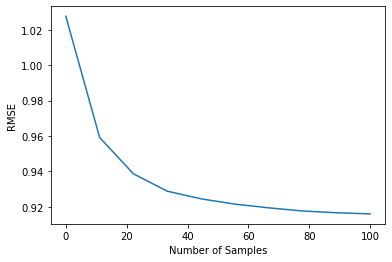

In [197]:
import matplotlib.pyplot as plt
x = np.linspace(0,100,10)
plt.plot(x,Y)
plt.ylabel('RMSE')
plt.xlabel('Number of Samples')
plt.show()